In [1]:
import numpy as np
import os, re, copy
import cv2 as cv
import tools
from cellpose import utils, io
import matplotlib.pyplot as plt
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from numba_transforms import nn_scale_image

my_data = "example_data"
segments_path = "cellpose_output/"

In [2]:
# Get the filenames for our segmentation datasets. 
segmented = os.listdir(segments_path)
for fichier in segmented[:]: 
    if not(fichier.endswith(".npy")):
        segmented.remove(fichier)

# Sort the filenames by timepoint. 
segmented.sort(key = tools.natural_keys)

# Create a list that records the timepoints for every image. 
time_list = []
for segment in segmented:
    time_list.append(int(re.findall(r'\d+', segment)[0]))

In [3]:
# Initialize lists.
im_list = []

# Fill lists with img and outline data from each segment
for segment, time in zip(segmented, time_list):
    # Load up the segmentation data. 
    dat = np.load(segments_path + segment, allow_pickle=True).item()
        
    #Populate list with each original image
    im = dat['img']
    im_list.append(im)

In [60]:
img0 = copy.deepcopy(im_list[30])
img = copy.deepcopy(img0[:,:-100])

In [61]:
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
segments = watershed(-gray)

In [62]:
padded = cv.copyMakeBorder(segments,1,1,1,1,cv.BORDER_CONSTANT,None,value=0)
outlines = np.zeros(np.shape(jmg))

In [65]:
(m,n) = np.shape(gray)
for i in range(m):
    for j in range (n):
        if np.any(padded[i:i+3,j:j+3]>padded[i+1,j+1]):
            img0[i,j,:] = [255,0,0]

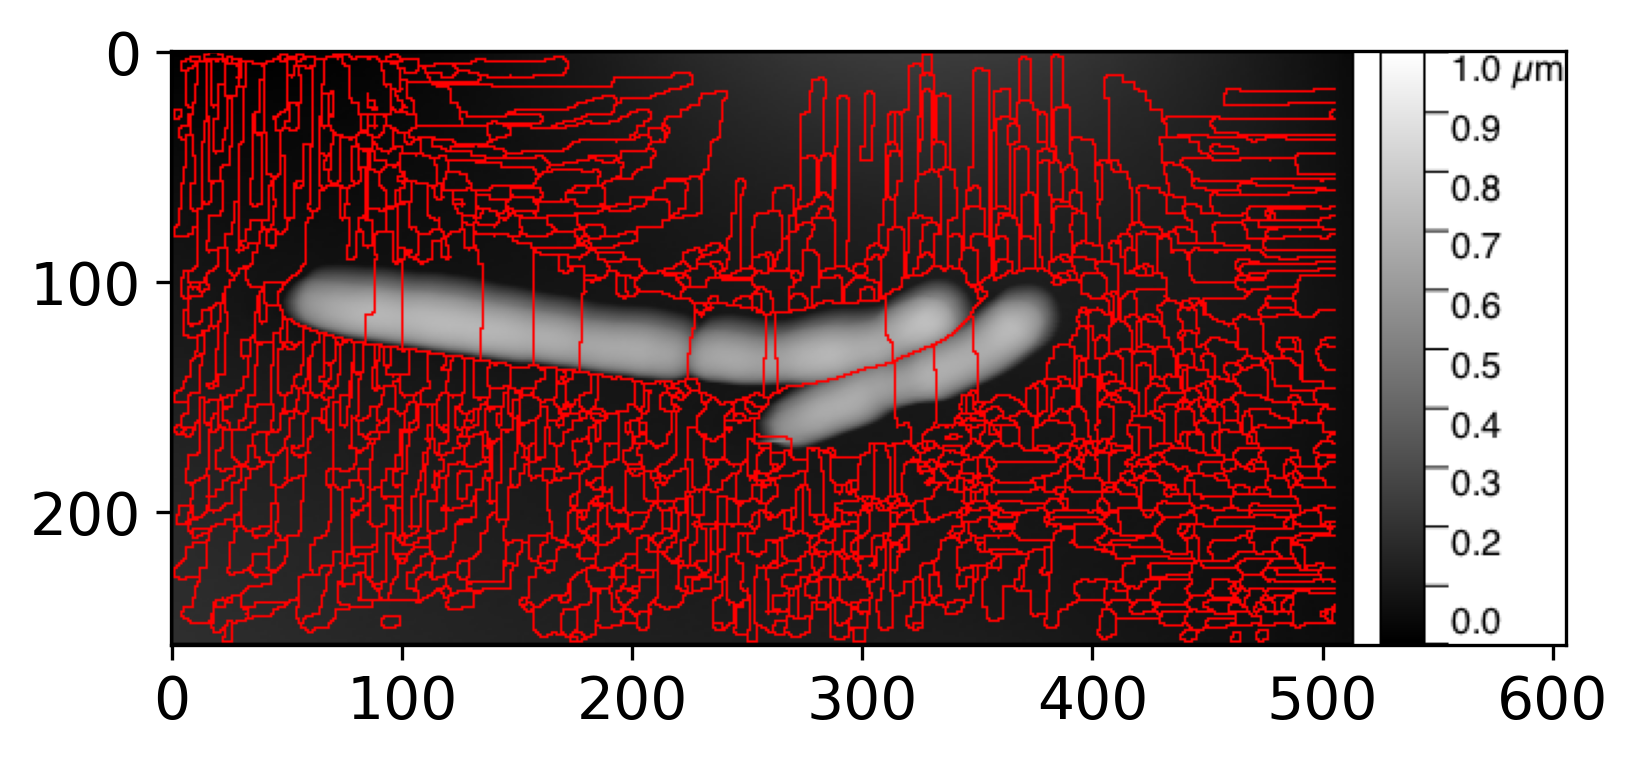

In [67]:
plt.imshow(img0)

In [5]:
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
ret, thresh = cv.threshold(gray,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)

In [6]:
# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv.morphologyEx(thresh,cv.MORPH_OPEN,kernel, iterations = 2)

In [7]:
# sure background area
sure_bg = cv.dilate(opening,kernel,iterations=3)

In [8]:
# Finding sure foreground area
dist_transform = cv.distanceTransform(opening,cv.DIST_L2,5)
ret, sure_fg = cv.threshold(dist_transform,0.7*dist_transform.max(),255,0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv.subtract(sure_bg,sure_fg)

In [9]:
# Marker labelling
ret, markers = cv.connectedComponents(sure_fg)
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1
# Now, mark the region of unknown with zero
markers[unknown==255] = 0

In [10]:
markers = cv.watershed(img,markers)
img[markers == -1] = [255,0,0]

In [11]:
img0[:,:-100]=img

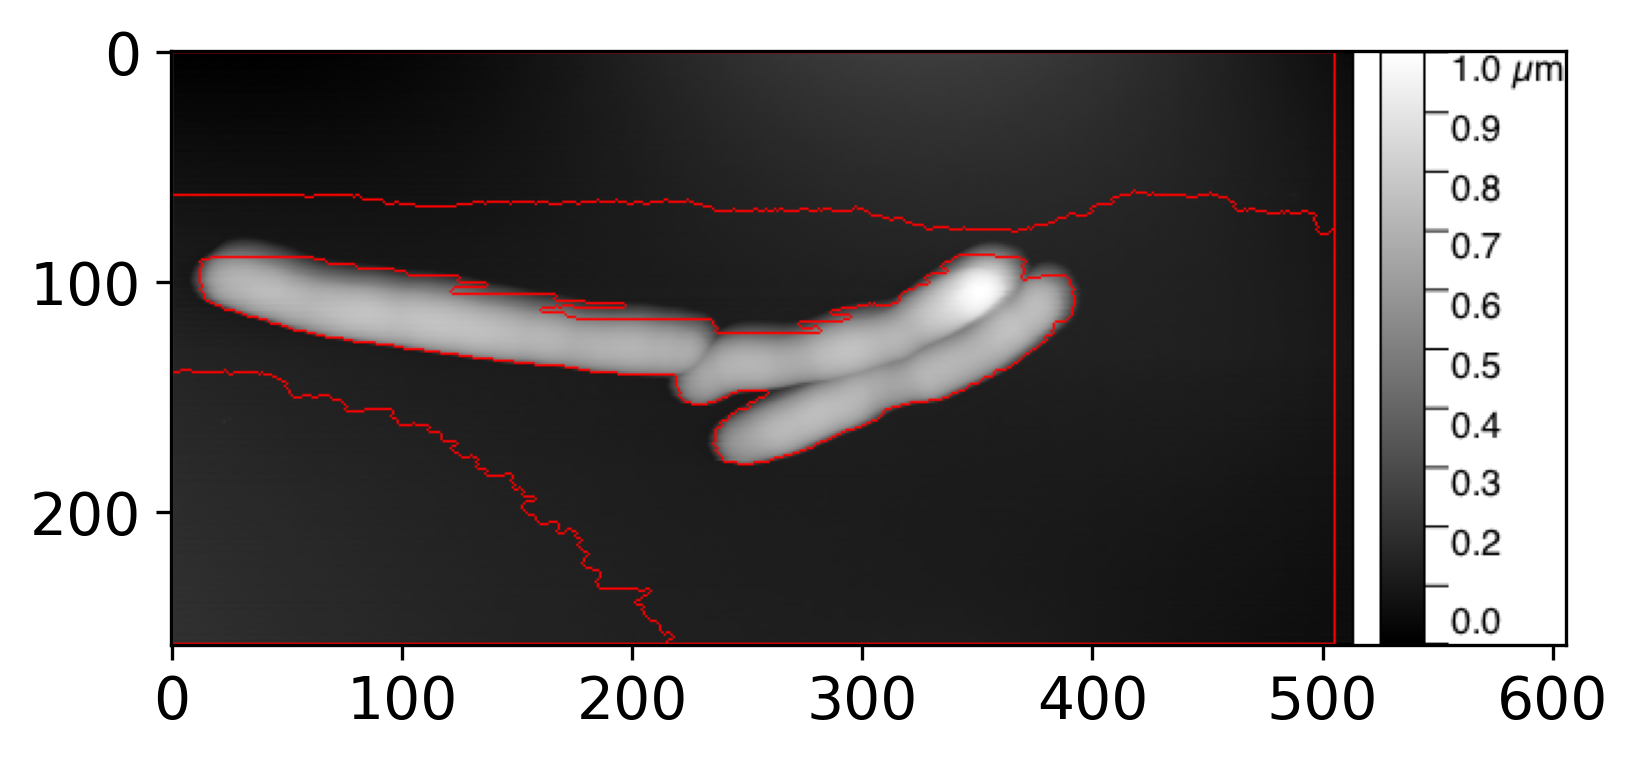

In [12]:
plt.imshow(img0)

In [73]:
len(im_list)

39